In [1]:
%matplotlib inline
import numpy as np
import json
import matplotlib.pyplot as plt

In [2]:
# Load the NeuroTree distance file.  
with open('dist_mtx.txt','rb') as f:
    dist_data = json.loads(f.read().decode('latin1'))

In [3]:
# Parse the NeuroTree distance file into a matrix.  
ancestors = list(set([x['p0'] for x in dist_data])) # Extract ancestor list
regulars = list(set([x['p1'] for x in dist_data]).union(set([x['p2'] for x in dist_data]))) # Extract regular list.  
n_regulars = len(regulars) # Number of regulars.
dist_matrix = -1.0 * np.ones((n_regulars,n_regulars)) # Matrix of distances, filled with -1 (no path).  
for entry in dist_data: # Iterate over entries in the distance data.  
    p0,p1,p2,d = [entry[i] for i in ['p0','p1','p2','d']]
    d = np.inf if d=='-1' else int(d)
    x1 = regulars.index(p1) # Matrix index of individual with id p1.  
    x2 = regulars.index(p2) # Matrix index of individual with id p2.  
    dist_matrix[x1,x2] = d # Set forward distance to d.  
    dist_matrix[x2,x1] = d # Set reverse distance to d (for symmetry).  
for i in range(n_regulars): # For each individual.  
    dist_matrix[i,i] = 0 # Set the diagonal entry (self distance) to 0.  

In [4]:
# Create an adjacency matrix.  
adj_matrix = (dist_matrix==1).astype(int)

In [5]:
# Compute its eigenvalues and eigenvectors
evls,evcts = np.linalg.eigh(adj_matrix)

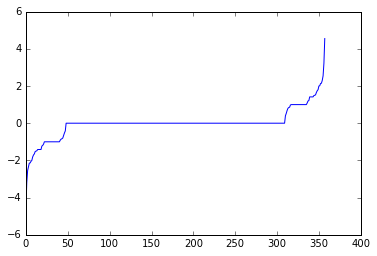

In [6]:
#Plot eigenvalues in ascending order
plt.plot(evls);

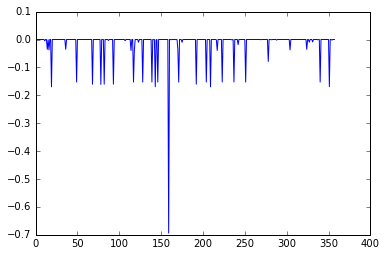

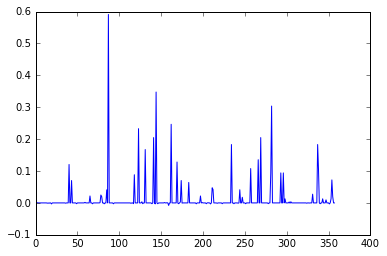

In [7]:
# Plot node weights for the last eigenvector (corresponding to the most positive eigenvalue)
plt.plot(evcts[:,-1])
plt.figure()
# Plot node weights for the second to last eigenvector (corresponding to the second most positive eigenvalue)
plt.plot(evcts[:,-2]);

In [8]:
# How many ancestors among the nodes we have in the matrix, vs ancestors overall?
len(set(regulars).intersection(ancestors)),len(ancestors)

(58, 437)

In [9]:
# A node name extraction function.  
from neurotree_api import get_neurotree_node_info
def node2name(node):
    node = int(node)
    info = get_neurotree_node_info(node)
    return '%s %s' % (info['firstname'],info['lastname'])

In [10]:
# Print important nodes in each eigenvector.  
# The nodes within an eigenvector are not necessarily related (although they often will be).
# In some cases they can be opposing forces (i.e. together they are informative about lineage).

for rank in range(10):
    eigenvector = np.abs(evcts[:,-1-rank]) # Take absolute value so we can find most important values 
                                           # and not worry about sign.  
    results = sorted(zip(eigenvector,regulars),key=lambda x:x[0],reverse=True) # Sort nodes by weight in eigenvector.
    print("Eigenvector %d:" % rank)
    for depth in range(5): # Print the top 5 nodes in each eigenvector.  
        print("\t%d) %s" % (depth+1,node2name(results[depth][1])))

Eigenvector 0:
	1) Bert Sakmann
	2) Andreas Draguhn
	3) Peter Jonas
	4) Jason Kerr
	5) Greg Stuart
Eigenvector 1:
	1) David Prince
	2) Phillip Schwartzkroin
	3) Barry Connors
	4) John Huguenard
	5) Tom Brown
Eigenvector 2:
	1) Jean Rossier
	2) Rodolfo Llinu00e1s
	3) Serge Charpak
	4) Etienne Audinat
	5) Jacques Glowinski
Eigenvector 3:
	1) Phillip Schwartzkroin
	2) Paul Buckmaster
	3) Barry Connors
	4) Scott Baraban
	5) F Dudek
Eigenvector 4:
	1) Rodolfo Llinu00e1s
	2) Jean Rossier
	3) Anthony Grace
	4) Etienne Audinat
	5) Brian Macvicar
Eigenvector 5:
	1) Peter Somogyi
	2) Eberhard Buhl
	3) Dominique Engel
	4) Zoltan Nusser
	5) Stuart Cobb
Eigenvector 6:
	1) Stephen Kitai
	2) Barry Connors
	3) Gerald Finnerty
	4) John Jefferys
	5) Charles Wilson
Eigenvector 7:
	1) Stephen Kitai
	2) Charles Wilson
	3) Dietmar Plenz
	4) Yasuo Kawaguchi
	5) John Jefferys
Eigenvector 8:
	1) F Dudek
	2) Scott Baraban
	3) Sanjay Kumar
	4) Paul Buckmaster
	5) John Huguenard
Eigenvector 9:
	1) German Barrionu